# 네이버 영화평 감성분석

### 한글 폰트 사용

In [ ]:
from tensorflow.

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
# 설치 뒤 font-manager rebuild
import matplotlib.font_manager as fm
fm._rebuild()

### 설치 후 런타임 다시 시작하기

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='NanumGothic')

### KoNLPy 설치

In [ ]:
!pip install Konlpy

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 450kB 30.3MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import konlpy
konlpy.__version__

'0.5.2'

### 파일 업로드

In [ ]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving naver_movie_train.tsv to naver_movie_train.tsv


In [ ]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving naver_movie_test.tsv to naver_movie_test.tsv


In [ ]:
import pandas as pd 
train_df = pd.read_csv('naver_movie_train.tsv', sep='\t')
test_df = pd.read_csv('naver_movie_test.tsv', sep='\t')
train_df.head(3)

,Unnamed: 0,id,document,label
0,0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,2,10265843,너무재밓었다그래서보는것을추천한다,0


### 한글 형태소 분석

In [ ]:
from konlpy.tag import Okt
import tqdm.notebook as tn

In [ ]:
# 토큰화와 불용어 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']
okt = Okt()

In [ ]:
X_train = []
for sentence in tn.tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem=True)
    temp_X = ' '.join([word for word in morphs if not word in stopwords])
    X_train.append(temp_X)

In [ ]:
X_test = []
for sentence in tn.tqdm(test_df.document):
    morphs = okt.morphs(sentence, stem=True)
    temp_X = ' '.join([word for word in morphs if not word in stopwords])
    X_test.append(temp_X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[:,:-1], df[:,-1], 
)

In [ ]:
X_train[:3]

['아 더빙 진짜 짜증나다 목소리',
 '흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍다 않다',
 '너 무재 밓었 다그 래서 보다 추천 다']

### 케라스로 인코딩

In [ ]:
import numpy as np 
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# 상위 30,000개의 단어로 인코딩
max_words = 30000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[:3]

[[48, 450, 15, 256, 655],
 [929, 453, 40, 598, 1, 210, 1445, 23, 957, 671, 18],
 [382, 2440, 25011, 2311, 5667, 2, 218, 8]]

In [ ]:
# 전체 데이터의 길이 분포
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(map(len, X_train))/len(X_train))

리뷰 최대 길이: 69
리뷰 평균 길이: 10.660699220116468


In [ ]:
# 샘플의 길이를 40으로 셋팅
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
y_train = train_df.label.values
y_test = test_df.label.values

### 1. LSTM 모델 정의/설정/학습/평가

In [ ]:
model = Sequential([
                    Embedding(max_words, 120),
                    LSTM(256),
                    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         3600000   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               386048    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 3,986,305
Trainable params: 3,986,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
mc = ModelCheckpoint('naver-lstm-best-model.h5', save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, 
                    batch_size=60, epochs=4, callbacks=[mc])

Epoch 1/4
1944/1944 [==============================] - 122s 59ms/step - loss: 0.3876 - accuracy: 0.8225 - val_loss: 0.3536 - val_accuracy: 0.8471
Epoch 2/4
1944/1944 [==============================] - 112s 57ms/step - loss: 0.2908 - accuracy: 0.8766 - val_loss: 0.3413 - val_accuracy: 0.8525
Epoch 3/4
1944/1944 [==============================] - 110s 56ms/step - loss: 0.2355 - accuracy: 0.9035 - val_loss: 0.3772 - val_accuracy: 0.8497
Epoch 4/4
1944/1944 [==============================] - 110s 57ms/step - loss: 0.1886 - accuracy: 0.9240 - val_loss: 0.4148 - val_accuracy: 0.8461


In [ ]:
model_file = 'naver-lstm-best-model.h5'
best_model = load_model(model_file)

In [ ]:
best_model.evaluate(X_test, y_test)

1532/1532 [==============================] - 13s 8ms/step - loss: 0.3475 - accuracy: 0.8486


[0.34752577543258667, 0.8485968112945557]

### 학습과정 시각화

In [ ]:
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(1, len(y_acc)+1)

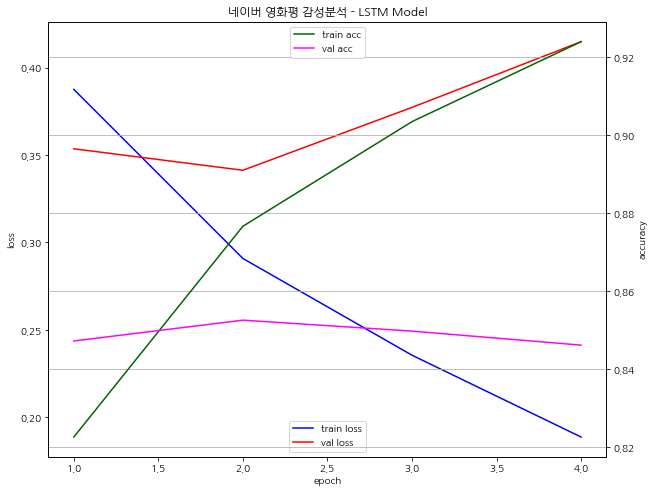

In [ ]:
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c='blue', label='train loss')
ax0.plot(x_len, y_vloss, c='red', label='val loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c='darkgreen', label='train acc')
ax1.plot(x_len, y_vacc, c='magenta', label='val acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center'); ax1.legend(loc='upper center')
plt.title('네이버 영화평 감성분석 - LSTM Model')
plt.grid(); plt.show()

### 2. GRU Model

In [ ]:
model2 = Sequential([
                    Embedding(max_words, 120),
                    GRU(256),
                    Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 120)         3600000   
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               290304    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 3,890,561
Trainable params: 3,890,561
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
mc2 = ModelCheckpoint('naver-gru-best-model.h5', save_best_only=True)

In [ ]:
history2 = model2.fit(X_train, y_train, validation_split=0.2, 
                     batch_size=60, epochs=4, callbacks=[mc2])

Epoch 1/4
1944/1944 [==============================] - 104s 53ms/step - loss: 0.1301 - accuracy: 0.9494 - val_loss: 0.5035 - val_accuracy: 0.8353
Epoch 2/4
1944/1944 [==============================] - 105s 54ms/step - loss: 0.1001 - accuracy: 0.9616 - val_loss: 0.5823 - val_accuracy: 0.8286
Epoch 3/4
1944/1944 [==============================] - 104s 53ms/step - loss: 0.0809 - accuracy: 0.9689 - val_loss: 0.6954 - val_accuracy: 0.8308
Epoch 4/4
1944/1944 [==============================] - 102s 53ms/step - loss: 0.0667 - accuracy: 0.9746 - val_loss: 0.7564 - val_accuracy: 0.8265


In [ ]:
model_file2 = 'naver-gru-best-model.h5'
best_model2 = load_model(model_file2)

In [ ]:
best_model2.evaluate(X_test, y_test)

1532/1532 [==============================] - 11s 7ms/step - loss: 0.5115 - accuracy: 0.8300


[0.5115455389022827, 0.8299826383590698]

### 3. SimpleRNN Model

In [ ]:
from tensorflow.keras.layers import SimpleRNN

In [ ]:
model3 = Sequential([
                    Embedding(max_words, 120),
                    SimpleRNN(128),
                    Dense(1, activation='sigmoid')
])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 120)         3600000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               31872     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,632,001
Trainable params: 3,632,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
mc3 = ModelCheckpoint('naver-srnn-best-model.h5', save_best_only=True)

In [ ]:
history3 = model3.fit(X_train, y_train, validation_split=0.2, 
                     batch_size=60, epochs=5, callbacks=[mc3])

Epoch 1/5
1944/1944 [==============================] - 176s 90ms/step - loss: 0.4145 - accuracy: 0.8079 - val_loss: 0.3870 - val_accuracy: 0.8291
Epoch 2/5
1944/1944 [==============================] - 173s 89ms/step - loss: 0.3206 - accuracy: 0.8652 - val_loss: 0.3909 - val_accuracy: 0.8333
Epoch 3/5
1944/1944 [==============================] - 175s 90ms/step - loss: 0.2372 - accuracy: 0.9046 - val_loss: 0.4398 - val_accuracy: 0.8194
Epoch 4/5
1944/1944 [==============================] - 177s 91ms/step - loss: 0.1834 - accuracy: 0.9286 - val_loss: 0.5380 - val_accuracy: 0.8048
Epoch 5/5
1944/1944 [==============================] - 176s 91ms/step - loss: 0.1929 - accuracy: 0.9241 - val_loss: 0.5178 - val_accuracy: 0.8131


In [ ]:
model_file3 = 'naver-srnn-best-model.h5'
best_model3 = load_model(model_file3)

In [ ]:
best_model3.evaluate(X_test, y_test)

1532/1532 [==============================] - 11s 7ms/step - loss: 0.3889 - accuracy: 0.8276


[0.38891419768333435, 0.8276354670524597]

### 4. Conv1D + LSTM

In [ ]:
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D

In [ ]:
model4 = Sequential([
    Embedding(max_words, 120),
    Dropout(0.5),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(2),
    LSTM(256),
    Dense(1, activation='sigmoid')
])
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 120)         3600000   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 120)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         76928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 4,071,425
Trainable params: 4,071,425
Non-trainable params: 0
____________________________________________

In [ ]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
mc4 = ModelCheckpoint('naver-conv1d-lstm-best-model.h5', save_best_only=True)

In [ ]:
history4 = model4.fit(X_train, y_train, validation_split=0.2, 
                     batch_size=60, epochs=4, callbacks=[mc4])

Epoch 1/4
1944/1944 [==============================] - 128s 52ms/step - loss: 0.3895 - accuracy: 0.8203 - val_loss: 0.3427 - val_accuracy: 0.8523
Epoch 2/4
1944/1944 [==============================] - 103s 53ms/step - loss: 0.2972 - accuracy: 0.8732 - val_loss: 0.3392 - val_accuracy: 0.8537
Epoch 3/4
1944/1944 [==============================] - 102s 52ms/step - loss: 0.2465 - accuracy: 0.8981 - val_loss: 0.3581 - val_accuracy: 0.8519
Epoch 4/4
1944/1944 [==============================] - 98s 50ms/step - loss: 0.2057 - accuracy: 0.9165 - val_loss: 0.3829 - val_accuracy: 0.8516


In [ ]:
model_file4 = 'naver-conv1d-lstm-best-model.h5'
best_model4 = load_model(model_file4)

In [ ]:
best_model4.evaluate(X_test, y_test)

1532/1532 [==============================] - 10s 6ms/step - loss: 0.3440 - accuracy: 0.8483


[0.3439914584159851, 0.8483314514160156]

### 5. n_embed, n_rnn 변경

In [ ]:
model5 = Sequential([
    Embedding(max_words, 150),
    Dropout(0.5),
    Conv1D(256, 5, activation='relu'),
    MaxPooling1D(2),
    LSTM(512),
    Dense(1, activation='sigmoid')
])
model5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 150)         4500000   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 150)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         192256    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 6,267,681
Trainable params: 6,267,681
Non-trainable params: 0
____________________________________________

In [ ]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
mc5 = ModelCheckpoint('naver-conv1d-lstm-best-model2.h5', save_best_only=True)

In [ ]:
history5 = model5.fit(X_train, y_train, validation_split=0.2, 
                     batch_size=60, epochs=4, callbacks=[mc5])

Epoch 1/4
1944/1944 [==============================] - 149s 75ms/step - loss: 0.3883 - accuracy: 0.8208 - val_loss: 0.3426 - val_accuracy: 0.8518
Epoch 2/4
1944/1944 [==============================] - 146s 75ms/step - loss: 0.2938 - accuracy: 0.8743 - val_loss: 0.3411 - val_accuracy: 0.8543
Epoch 3/4
1944/1944 [==============================] - 147s 76ms/step - loss: 0.2395 - accuracy: 0.9011 - val_loss: 0.3597 - val_accuracy: 0.8518
Epoch 4/4
1944/1944 [==============================] - 146s 75ms/step - loss: 0.1945 - accuracy: 0.9216 - val_loss: 0.4069 - val_accuracy: 0.8493


In [ ]:
model_file5 = 'naver-conv1d-lstm-best-model2.h5'
best_model5 = load_model(model_file5)

In [ ]:
best_model5.evaluate(X_test, y_test)

1532/1532 [==============================] - 14s 9ms/step - loss: 0.3444 - accuracy: 0.8487


[0.34438323974609375, 0.8487396836280823]